In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

#scraping
import requests
import os
from bs4 import BeautifulSoup
from random import randint
from time import sleep

#nlp
import nltk
import rutokenizer
import rupostagger
import rulemma
import string
from collections import Counter
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

In [2]:
%matplotlib inline
%config InlineBackend.figure_format="retina"

sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.5)

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

# Save all reviews

In [4]:
page_list = os.listdir(path="source_1")

In [5]:
def get_reviews_urls(page_list):
    urls = []
    for page in page_list:
        with open('source_1/'+page) as fp:
            soup = BeautifulSoup(fp)
            urls_reviews = soup.find_all("a", class_="review-btn review-read-link")
            for tag in urls_reviews:
                urls.append(tag.attrs['href'])
    return urls

In [6]:
urls = get_reviews_urls(page_list)

In [229]:
def save_urls(urls):
    for url in urls:
        file_name = url[20:]
        cookies = {'ssid':'1160706392', 
                   'refreg': url,
                   '__gads':'ID=e63abff673803598:T=1583922601:S=ALNI_Mbvb7AStYcfGqBuImET-MTYHNuUxg', 
                   'ROBINBOBIN':'9gfghrcmbvpa9g85u7759ottj4'}
        headers = {'User-Agent': 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:73.0) Gecko/20100101 Firefox/73.0'}
    
        r = requests.get(url, headers = headers, cookies = cookies)
        with open('source_2/'+file_name, 'w') as output_file:
            output_file.write(r.text)
            sleep(randint(1,5))

In [230]:
# you can not run this cell, becouse the pages are already saved in source_2
save_urls(urls)

# Make dataset

In [7]:
def make_dataset(urls):

    rows_list = []
    
    for url in urls:
        file_name = url[20:]
        with open('source_2/'+file_name) as fp:
            soup = BeautifulSoup(fp)
 
        user_name = soup.find_all("span", itemprop="name")[1].text.strip()
        if ',' in soup.find("div", class_="user-location").text.strip():
            user_country, user_city = soup.find("div", class_="user-location").text.strip().split(',')
        else:
            user_country = soup.find("div", class_="user-location").text.strip()
            user_city = np.nan
            
        user_karma = soup.find("div", class_=["karma karma1", "karma karma0", "karma karma-1"]).text.strip()

        date_review = soup.find_all("span", class_="tooltip-right")[1].text.strip()
        title_review = soup.find("h1").text.strip()[soup.find("h1").text.strip().index(') -')+4:]
        plus_review = soup.find("div", class_="review-plus").text.strip()
        minus_review = soup.find("div", class_="review-minus").text.strip()
        body_review = soup.find("div", class_="review-body description").text.strip()
        coment_count_review = soup.find("h3").text.strip().split('(')[1][:-1]
        
        if len(soup.table.contents[1].text.strip())!=0:
            dict_station = {}
            for i in range(len(soup.table.contents[1].find_all('td'))):
                if i%2==0:
                    dict_station[soup.table.contents[1].find_all('td')[i].text.strip()]=\
                    soup.table.contents[1].find_all('td')[i+1].text.strip()
        
                    if 'Страна:' in dict_station.keys():
                        country_station = dict_station['Страна:']
                    else:
                        country_station = np.nan
                    if 'Регион (край, область, штат):' in dict_station.keys():
                        region_station = dict_station['Регион (край, область, штат):']
                    else:
                        region_station = np.nan
                    if 'Район:' in dict_station.keys():
                        district_station = dict_station['Район:']
                    else:
                        district_station = np.nan
                    if 'Город или поселок:' in dict_station.keys():
                        city_station = dict_station['Город или поселок:']
                    else:
                        city_station = np.nan
                    if 'Улица:' in dict_station.keys():
                        street_station = dict_station['Улица:']
                    else:
                        street_station = np.nan
                    if 'Дом №:' in dict_station.keys():
                        house_station = dict_station['Дом №:']
                    else:
                        house_station = np.nan        

        result_review = soup.find("i", class_="summary").text.strip()
        result_rating = soup.find("abbr", class_="rating").attrs['title']
        
        if len(soup.find_all("td", class_="recommend-ratio yes")) == 1:
            result_recomendation = soup.find_all("td", class_="recommend-ratio yes")[0].text.strip()
        else:
            result_recomendation = 'НЕТ'
            
        if len(soup.find_all("div", class_="rating-item tooltip-top"))==5:
            price_mark = soup.find_all("div", class_="rating-item tooltip-top")[0].\
            contents[3].contents[0]['style'].split(':')[1][1:-2]
            quality_mark = soup.find_all("div", class_="rating-item tooltip-top")[1].\
            contents[3].contents[0]['style'].split(':')[1][1:-2]
            personal_mark = soup.find_all("div", class_="rating-item tooltip-top")[2].\
            contents[3].contents[0]['style'].split(':')[1][1:-2]
            way_mark = soup.find_all("div", class_="rating-item tooltip-top")[3].\
            contents[3].contents[0]['style'].split(':')[1][1:-2]
            ad_mark = soup.find_all("div", class_="rating-item tooltip-top")[4].\
            contents[3].contents[0]['style'].split(':')[1][1:-2]
        elif len(soup.find_all("div", class_="rating-item tooltip-top"))==4:
            price_mark = soup.find_all("div", class_="rating-item tooltip-top")[0].\
            contents[3].contents[0]['style'].split(':')[1][1:-2]
            quality_mark = soup.find_all("div", class_="rating-item tooltip-top")[1].\
            contents[3].contents[0]['style'].split(':')[1][1:-2]
            personal_mark = soup.find_all("div", class_="rating-item tooltip-top")[2].\
            contents[3].contents[0]['style'].split(':')[1][1:-2]
            way_mark = soup.find_all("div", class_="rating-item tooltip-top")[3].\
            contents[3].contents[0]['style'].split(':')[1][1:-2]
            ad_mark = np.nan
        elif len(soup.find_all("div", class_="rating-item tooltip-top"))==3:
            price_mark = soup.find_all("div", class_="rating-item tooltip-top")[0].\
            contents[3].contents[0]['style'].split(':')[1][1:-2]
            quality_mark = soup.find_all("div", class_="rating-item tooltip-top")[1].\
            contents[3].contents[0]['style'].split(':')[1][1:-2]
            personal_mark = soup.find_all("div", class_="rating-item tooltip-top")[2].\
            contents[3].contents[0]['style'].split(':')[1][1:-2]
            way_mark = np.nan
            ad_mark = np.nan        
        else:
            price_mark = np.nan
            quality_mark = np.nan
            personal_mark = np.nan
            way_mark = np.nan
            ad_mark = np.nan
                
        url_data = {'user_name': user_name,
                    'user_country': user_country,
                    'user_city': user_city,
                    'user_karma': user_karma,
                    'date_review': date_review,
                    'title_review': title_review,
                    'plus_review': plus_review,
                    'minus_review': minus_review,
                    'body_review': body_review,
                    'coment_count_review': coment_count_review,
                    'country_station': country_station,
                    'region_station': region_station,
                    'district_station': district_station,
                    'city_station': city_station,
                    'street_station': street_station,
                    'house_station': house_station,
                    'result_review': result_review,
                    'result_rating': result_rating,
                    'result_recomendation':result_recomendation,
                    'price_mark': price_mark,
                    'quality_mark': quality_mark,
                    'personal_mark': personal_mark,
                    'way_mark': way_mark,
                    'ad_mark': ad_mark,
                    'id': url[27:-5]
                    }
        
        rows_list.append(url_data)
        
    df = pd.DataFrame(rows_list)
    df = df.set_index('id')
    
    return df

In [8]:
data = make_dataset(urls)

# Transform dataset

In [10]:
data.columns

Index(['user_name', 'user_country', 'user_city', 'user_karma', 'date_review',
       'title_review', 'plus_review', 'minus_review', 'body_review',
       'coment_count_review', 'country_station', 'region_station',
       'district_station', 'city_station', 'street_station', 'house_station',
       'result_review', 'result_rating', 'result_recomendation', 'price_mark',
       'quality_mark', 'personal_mark', 'way_mark', 'ad_mark'],
      dtype='object')

In [11]:
data['user_city'] = data['user_city'].str[1:]

In [12]:
data.loc[data['user_city'] == data['city_station'], 'hometown'] = 1
data.loc[data['user_city'] != data['city_station'], 'hometown'] = 0

In [13]:
data.loc[data['user_country'] == data['country_station'], 'homecountry'] = 1
data.loc[data['user_country'] != data['country_station'], 'homecountry'] = 0

In [14]:
adress = data.groupby(['city_station','street_station','house_station']).count()['user_name']
adress = adress[adress>1].reset_index()
adress['number_station'] = [i for i in range(1,len(adress)+1)]

In [15]:
data['number_station']=0

for i in data.index:
    for a in adress.index:
        if (data.loc[i]['city_station']==adress.loc[a]['city_station']) and\
        (data.loc[i]['street_station']==adress.loc[a]['street_station']) and\
        (data.loc[i]['house_station']==adress.loc[a]['house_station']):
            data['number_station'][i] = adress['number_station'][a]

couner = len(adress)+1
for i in data.index:
    if data['number_station'][i]==0:
        data['number_station'][i] = couner
        couner = couner+1

/home/mneminic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/mneminic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]


In [16]:
data.loc[data['result_recomendation']=='ДА','target'] = data['result_rating'].astype(int) + 1

In [17]:
data.loc[data['result_recomendation']=='НЕТ','target'] = data['result_rating'].astype(int)

In [18]:
data.loc[data['target']>3, 'bi_target'] = 1

In [19]:
data.loc[data['target']<=3, 'bi_target'] = 0

In [20]:
data['bi_target'].value_counts()

0.0    129
1.0    102
Name: bi_target, dtype: int64

In [21]:
data['all_text'] = data['title_review']+'. '+data['plus_review']+'. '+data['minus_review']+\
'. '+data['body_review']+'. '+data['result_review']

# Prepare text data

In [23]:
lemmatizer = rulemma.Lemmatizer()
lemmatizer.load()
tokenizer = rutokenizer.Tokenizer()
tokenizer.load()
tagger = rupostagger.RuPosTagger()
tagger.load()

In [24]:
def string_to_lem(string_data):
    lemmas = lemmatizer.lemmatize(tagger.tag(tokenizer.tokenize(string_data)))
    result = []
    for word, tags, lemma, *_ in lemmas:
        result.append(lemma)
    return result

In [25]:
data['all_text_lem'] = [string_to_lem(i) for i in data['all_text']]

In [26]:
stop_words = list(stopwords.words("russian"))
def delite_stop_words(string_data):
    new_string = [word for word in string_data if not word in stop_words]
    return new_string

In [27]:
data['all_text_stop'] = [delite_stop_words(i) for i in data['all_text_lem']]

In [28]:
table = str.maketrans('', '', string.punctuation)
def delite_punctuation(string_data):
    new_string = [w.translate(table) for w in string_data]
    return [value for value in new_string if value]

In [29]:
data['final_text'] = [delite_punctuation(i) for i in data['all_text_stop']]

In [31]:
data['corpus'] = [' '.join(i) for i in data['final_text']]

# Clusters for negative and positive reviews

In [223]:
vectorizer = TfidfVectorizer(max_df=100 ,min_df=2)

In [224]:
matrix = vectorizer.fit_transform(list(data['corpus']))

In [225]:
matrix.shape

(231, 2028)

In [270]:
model = KMeans(n_clusters=2)

In [271]:
pred = model.fit_predict(matrix.toarray())

In [272]:
print('errors: ',float(sum(pred != data['bi_target'])/len(data['bi_target'])))

errors:  0.12987012987012986


In [245]:
data['bi_pred'] = pred

# Cluster negative reviews

In [79]:
vectorizer_neg = TfidfVectorizer(max_df=50 ,min_df=2)

In [80]:
matrix_neg = vectorizer_neg.fit_transform(list(data[data['bi_target']==0]['corpus']))

In [81]:
matrix_neg.shape

(129, 1220)

In [82]:
model_neg = KMeans(n_clusters=2, random_state=42)

In [83]:
pred_neg = model_neg.fit_predict(matrix_neg.toarray())

In [84]:
df_neg = pd.DataFrame(pred_neg, index = data[data['bi_target']==0]['corpus'].index, columns =['pred_neg'])

In [86]:
data = pd.concat([data,df_neg],axis=1)

/home/mneminic/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


In [90]:
len(data[data['pred_neg']==0][['minus_review','pred_neg']]) # fail with staff, price, marketing and other

63

In [91]:
len(data[data['pred_neg']==1][['minus_review','pred_neg']]) # fail with quality oil

66

# Analize

### Fail with staff, price, marketing and other cluster

In [138]:
Counter_0 = Counter(' '.join(data[data['pred_neg']==0]['corpus']).split())

In [139]:
most_popular_words_0 = Counter_0.most_common(20)

In [273]:
most_popular_words_0 # карта, бонус, время, деньга, рубль, оператор

[('заправка', 142),
 ('бензин', 76),
 ('азс', 72),
 ('газпромнефть', 70),
 ('топливо', 56),
 ('карта', 48),
 ('это', 46),
 ('заправляться', 42),
 ('весь', 42),
 ('бонус', 42),
 ('время', 37),
 ('литр', 35),
 ('деньга', 34),
 ('рубль', 34),
 ('оператор', 33),
 ('очередь', 32),
 ('машина', 29),
 ('свой', 29),
 ('год', 28),
 ('бак', 28)]

### Fail with quality oil

In [274]:
Counter_1 = Counter(' '.join(data[data['pred_neg']==1]['corpus']).split())

In [275]:
most_popular_words_1 = Counter_1.most_common(20)

In [276]:
most_popular_words_1 # качество, плохой, 95, работать, бензин+топливо встречается в 2 раз чаще

[('бензин', 134),
 ('топливо', 99),
 ('азс', 94),
 ('качество', 72),
 ('заправка', 70),
 ('машина', 62),
 ('заправляться', 53),
 ('газпромнефть', 49),
 ('весь', 40),
 ('литр', 40),
 ('плохой', 39),
 ('это', 36),
 ('газпром', 36),
 ('очередь', 34),
 ('бак', 32),
 ('95', 28),
 ('заправиться', 28),
 ('мочь', 26),
 ('стать', 25),
 ('работать', 25)]

### Top best and worst station by marks

In [351]:
worst_marks_number_station = list(data.groupby('number_station')['target'].mean().sort_values()[:66].index)

In [352]:
worst_marks_index_station = [i for i in data.index if data['number_station'][i] in worst_marks_number_station]

In [372]:
worst_marks_station = data.loc[pd.Index(worst_marks_index_station)]\
[['number_station','country_station','city_station','street_station','house_station']]

In [373]:
worst_marks_station

,number_station,country_station,city_station,street_station,house_station
1096478,3,Россия,Магнитогорск,Магнитная,105Б
1254306,199,Россия,Иваново,NaN,NaN
1482780,17,Россия,Санкт-Петербург,NaN,NaN
1817453,146,Россия,Санкт-Петербург,NaN,NaN
2056315,148,Россия,Санкт-Петербург,Советская,55
2092011,149,Россия,Снежинск,NaN,NaN
2419070,201,Россия,Кстово,М7,243
2452226,57,Россия,Санкт-Петербург,ул. Фучика,8а
2874868,63,Россия,Москва,NaN,NaN
3010668,64,Беларусь,Минск,Партизанский проспект,NaN


In [377]:
best_marks_number_station = list(data.groupby('number_station')['target'].mean().sort_values()[169:].index)

In [378]:
best_marks_index_station = [i for i in data.index if data['number_station'][i] in best_marks_number_station]

In [379]:
best_marks_station = data.loc[pd.Index(best_marks_index_station)]\
[['number_station', 'country_station','city_station','street_station','house_station','result_rating']]

In [380]:
best_marks_station

,number_station,country_station,city_station,street_station,house_station,result_rating
1345343,172,NaN,NaN,NaN,NaN,5
1386901,196,Россия,Санкт-Петербург,десантников,21,5
1404528,173,NaN,NaN,NaN,NaN,5
1467907,53,NaN,NaN,NaN,NaN,5
1749938,54,Россия,Москва,NaN,NaN,5
1934126,147,Россия,Шатура,Пр. Ильича,66,5
2067184,175,Россия,Москва,NaN,NaN,5
2131108,114,Россия,Пошехонье,NaN,NaN,5
2347195,150,Россия,Пошехонье,NaN,NaN,5
2569683,58,Россия,Санкт-Петербург,NaN,NaN,5


### Change reviews over time

In [455]:
data['pred_neg'] = data['pred_neg'].fillna(2)

In [456]:
dict_pred = {0:'other fail reviews', 1:'oil fail reviews', 2:'positive reviews'}

In [457]:
data = data.replace({'pred_neg': dict_pred})

In [458]:
data['date_review'] = pd.to_datetime(data['date_review'])

In [459]:
drow_data = data.groupby(data['date_review'].map(lambda x: x.year))['pred_neg'].value_counts()

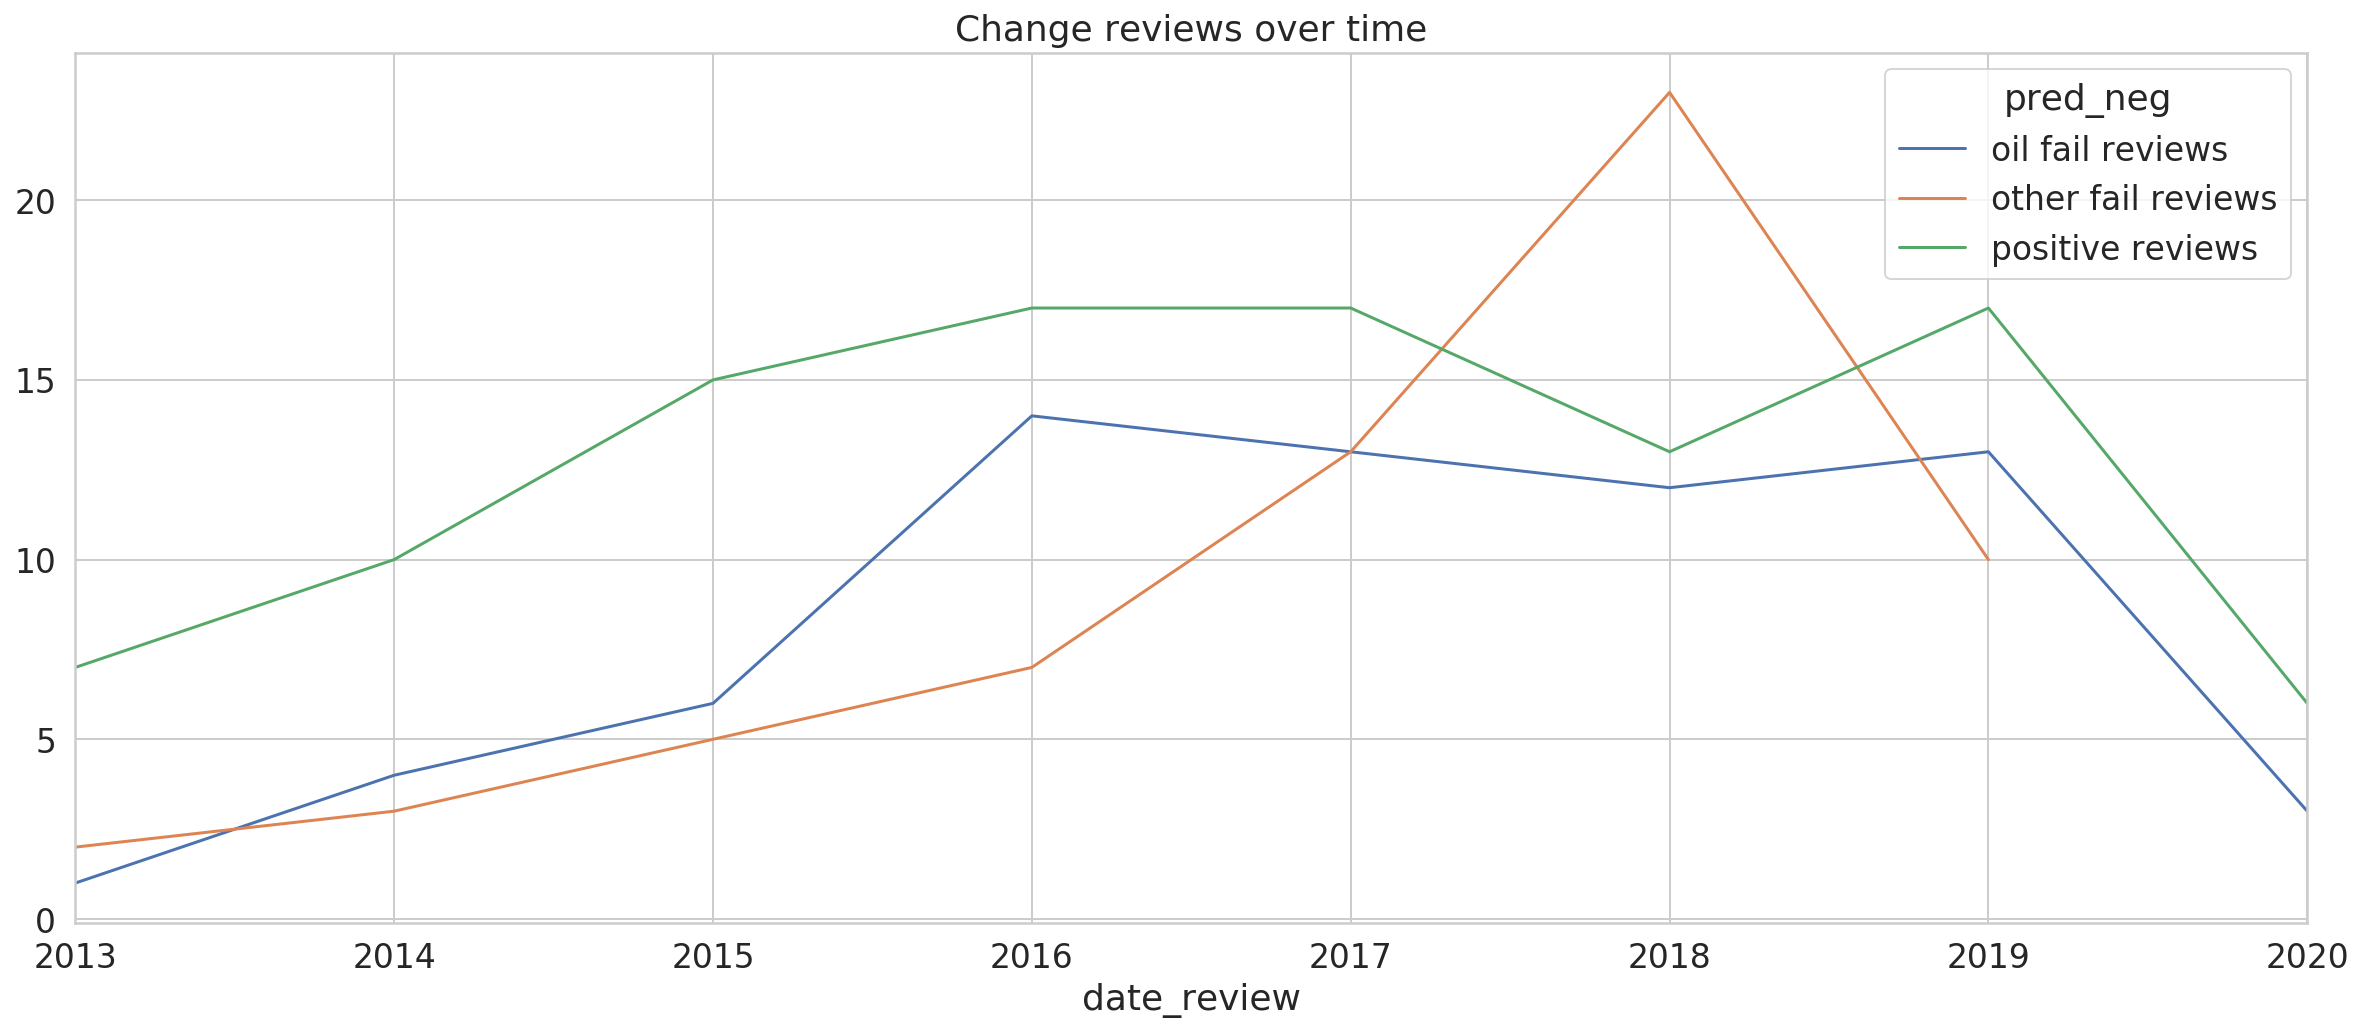

In [460]:
drow_data.unstack(level=1).plot(kind='line', subplots=False, figsize=(20,8), title='Change reviews over time');

In [ ]:
# Hичего необычного не замечено, кроме роста в 2018 почти в 2 раза
# количества негативных отзывов связанных с сервисом (цены, персонал, маркетинг)
# Рост общего количества отзывов с 2013 по 2016 скорее всего связан или с ростом
# сети заправок, или с ростом популярности https://otzovik.com 

### Other dependencies

In [474]:
data.groupby('pred_neg')['hometown'].value_counts()

pred_neg            hometown
oil fail reviews    1.0         34
                    0.0         32
other fail reviews  1.0         38
                    0.0         25
positive reviews    0.0         53
                    1.0         49
Name: hometown, dtype: int64

In [486]:
38/(38+25) # иногородние на 60% чаще жалуются на сервис, по сравнению с местными =)

0.6031746031746031

In [484]:
data['user_karma'] = data['user_karma'].astype(int)

In [489]:
data.loc[data['user_karma']>5, 'new_karma'] = 'good_carma'
data.loc[(data['user_karma']<5)&(data['user_karma']>=0), 'new_karma'] = 'norm_carma'
data.loc[data['user_karma']<0, 'new_karma'] = 'bad_carma'

In [491]:
data.groupby('pred_neg')['new_karma'].value_counts()

pred_neg            new_karma 
oil fail reviews    norm_carma    48
                    good_carma    15
                    bad_carma      1
other fail reviews  norm_carma    43
                    good_carma    18
                    bad_carma      1
positive reviews    good_carma    70
                    norm_carma    27
                    bad_carma      2
Name: new_karma, dtype: int64

In [ ]:
# ничего необычного не замечено

In [496]:
data.loc[data['city_station']=='Санкт-Петербург', 'big_city_label'] = 'Санкт-Петербург'
data.loc[data['city_station']=='Москва', 'big_city_label'] = 'Москва'
data['big_city_label'] = data['big_city_label'].fillna('other city')

In [498]:
data.groupby('pred_neg')['big_city_label'].value_counts()

pred_neg            big_city_label 
oil fail reviews    other city         43
                    Санкт-Петербург    12
                    Москва             11
other fail reviews  other city         35
                    Москва             17
                    Санкт-Петербург    11
positive reviews    other city         57
                    Москва             24
                    Санкт-Петербург    21
Name: big_city_label, dtype: int64

In [502]:
43/(12+11+43)

0.6515151515151515

In [503]:
35/(35+17+11)

0.5555555555555556

In [504]:
57/(57+24+21)

0.5588235294117647

In [506]:
data['big_city_label'].value_counts()

other city         135
Москва              52
Санкт-Петербург     44
Name: big_city_label, dtype: int64

In [ ]:
# На некачественное топливо в регионах жалуются чаще на 10% в сравнении с другими отзывами